# @Author Baokun

# Import Relevant Packages

In [424]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Baokun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Baokun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Baokun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Simple Data Exploration

In [423]:
df = pd.read_csv("data.csv")
df.describe()

,mediaCount,cityId,latitude,longitude,contactPhoneNumber,followingCount,followerCount,usertagsCount,geoMediaCount,shoppablePostsCount,followingTagCount
count,993.000000,6.410000e+02,637.000000,642.000000,4.140000e+02,993.000000,9.930000e+02,9.930000e+02,993.0,993.000000,993.000000
mean,1093.151057,5.403509e+13,1.418293,42.810382,3.787314e+12,1170.493454,3.336256e+05,1.571483e+04,0.0,1.621349,1.690836
std,1973.488560,5.942651e+13,12.365267,59.350103,5.103903e+12,8808.672655,5.762512e+06,3.294658e+05,0.0,15.465480,9.549008
min,0.000000,0.000000e+00,-37.817858,-123.143680,6.215009e+08,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000
25%,120.000000,0.000000e+00,-6.155250,0.000000,6.693737e+10,76.000000,1.226000e+03,3.900000e+01,0.0,0.000000,0.000000
50%,443.000000,0.000000e+00,0.000000,0.000000,6.281216e+12,383.000000,1.094700e+04,2.290000e+02,0.0,0.000000,0.000000
75%,1211.000000,1.060312e+14,0.000000,106.820868,6.282228e+12,958.000000,3.524300e+04,1.125000e+03,0.0,0.000000,1.000000
max,27742.000000,3.537165e+14,60.165610,151.215270,6.289564e+13,274812.000000,1.396263e+08,1.006420e+07,0.0,328.000000,168.000000


In [3]:
print(df.shape)
df.head(1)

(999, 21)


,username,brand,biography,mediaCount,cityId,latitude,longitude,zip,contactPhoneNumber,followingCount,...,usertagsCount,isBusiness,externalUrl,category,geoMediaCount,shoppablePostsCount,followingTagCount,picture,imageLabels,hasEmail
0,helthematic,True,Jalan Sawahan No. 60 Padang (Dekat Pertamina S...,16.0,NaN,NaN,NaN,NaN,NaN,17.0,...,3.0,False,NaN,NaN,0.0,0.0,0.0,https://scontent-iad3-1.cdninstagram.com/vp/a7...,"[('text', 0.92769134, 0.92769134), ('product',...",False


# Data Preprocessing

In [425]:
#Find all columns with only one unique value
for i in df.columns:
    if df[i].nunique()==1:
        print(i)

geoMediaCount


In [548]:
# Drop Columns that are unlikely to be useful
cols_to_drop = ['username','cityId', 'latitude','longitude', 'zip', 'contactPhoneNumber', "externalUrl",
                'geoMediaCount','picture',"category"]
cols_to_keep = [i for i in df.columns if i not in cols_to_drop]
dfkeepcols = df[cols_to_keep]
dfkeepcols.isnull().sum()

brand                    0
biography               53
mediaCount               6
followingCount           6
followerCount            6
usertagsCount            6
isBusiness             193
shoppablePostsCount      6
followingTagCount        6
imageLabels              0
hasEmail                 0
dtype: int64

In [638]:
#Drop multiple columns with NaN
def drop_multiple_cols_na(df):
    
    '''
    Input: DataFrame
    Output: DataFrame with rows that have multiple NA entries
    
    '''
    
    temp = None
    for i in df.columns:
        try:
            if temp == None:
                temp = df[i].isnull().apply(lambda x: 1 if x==True else 0)
        except:
            temp += df[i].isnull().apply(lambda x: 1 if x==True else 0)
    return temp
dfna = dfkeepcols[drop_multiple_cols_na(dfkeepcols) < (dfkeepcols.shape[1]/2)]
dfna.isnull().sum()

brand                    0
biography               47
mediaCount               0
followingCount           0
followerCount            0
usertagsCount            0
isBusiness             187
shoppablePostsCount      0
followingTagCount        0
imageLabels              0
hasEmail                 0
dtype: int64

# Feature Engineering

In [639]:
#Feature Engineer Using imagelabels
dfna["imageLabels"] = dfna["imageLabels"].str.lower()
dfna["imageLabels_cleaned"] = dfna["imageLabels"].apply(lambda x: " ".join(re.findall(r"\'[a-zA-Z]*\'",x)).replace("'",""))
lemmatizer = WordNetLemmatizer()
default_stopwords = set(nltk.corpus.stopwords.words('english'))
lst = []
allwords = []
for i in dfna["imageLabels_cleaned"]:
    words = nltk.word_tokenize(i)
    words = [word for word in words if len(word) > 1]
    words = [lemmatizer.lemmatize(word) for word in words]
    words = [word for word in words if word not in default_stopwords]
    lst += [" ".join(words)]
    allwords += words
dfna["imageLabels_cleaned"] = lst 

# Calculate frequency distribution
fdist = nltk.FreqDist(allwords)
# Output top 30 words
for word, frequency in fdist.most_common(30):
    print(u'{};{}'.format(word, frequency))

mostfreqwords = [word for word, frequency in fdist.most_common(30)]

product;499
font;446
text;339
logo;335
brand;319
graphic;294
line;255
area;194
girl;145
chin;96
beauty;90
forehead;84
shoulder;74
eyebrow;72
neck;72
circle;66
yellow;64
smile;64
hairstyle;64
cheek;63
symbol;61
face;56
black;55
nose;55
outerwear;54
angle;50
blue;50
lip;49
head;47
fun;45


<ipython-input-639-6c74e9695287>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfna["imageLabels"] = dfna["imageLabels"].str.lower()
<ipython-input-639-6c74e9695287>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfna["imageLabels_cleaned"] = dfna["imageLabels"].apply(lambda x: " ".join(re.findall(r"\'[a-zA-Z]*\'",x)).replace("'",""))
<ipython-input-639-6c74e9695287>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [640]:
#Feature Engineer imagelabels
def string_to_wordfreqdf(string):
    def get_word_freq(string):
        wordfreq = {}
        tokens = nltk.word_tokenize(string)
        for token in tokens:
            if token not in wordfreq.keys():
                wordfreq[token] = 1
            else:
                wordfreq[token] += 1
        return wordfreq

    wordfreq = get_word_freq(string)
    for i in wordfreq.keys():
        wordfreq[i] = [wordfreq[i]]
    return pd.DataFrame(wordfreq)

def get_BOW_cols(df, col, mostfreq):
    df_lst = []
    for i in df[col]:
        if i == "":
            df_lst += [pd.DataFrame({mostfreq[1]:[0]})]
        else:
            df_lst += [string_to_wordfreqdf(i)]
    newcols = pd.concat(df_lst)[mostfreq].replace(np.nan,0).reset_index().drop("index",axis=1).add_suffix("_{}".format(col))
    return newcols

newcols = get_BOW_cols(dfna, "imageLabels_cleaned",mostfreqwords)
newcols.shape

(993, 30)

In [662]:
newcols

,product_imageLabels_cleaned,font_imageLabels_cleaned,text_imageLabels_cleaned,logo_imageLabels_cleaned,brand_imageLabels_cleaned,graphic_imageLabels_cleaned,line_imageLabels_cleaned,area_imageLabels_cleaned,girl_imageLabels_cleaned,chin_imageLabels_cleaned,...,symbol_imageLabels_cleaned,face_imageLabels_cleaned,black_imageLabels_cleaned,nose_imageLabels_cleaned,outerwear_imageLabels_cleaned,angle_imageLabels_cleaned,blue_imageLabels_cleaned,lip_imageLabels_cleaned,head_imageLabels_cleaned,fun_imageLabels_cleaned
0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
989,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
990,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [641]:
#Feature Engineer Using biography
dfna["biography"] = dfna["biography"].str.lower()
dfna["biography"] = dfna["biography"].apply(str)
dfna["biography"] = dfna["biography"].apply(lambda x: " ".join(re.findall(r"[a-zA-Z]+",x)))
lemmatizer = WordNetLemmatizer()
default_stopwords = set(nltk.corpus.stopwords.words('english'))
lst = []
allwords = []
for i in dfna["biography"]:
    words = nltk.word_tokenize(i)
    words = [word for word in words if len(word) > 1]
    words = [lemmatizer.lemmatize(word) for word in words]
    words = [word for word in words if word not in default_stopwords]
    lst += [" ".join(words)]
    allwords += words
dfna["biography_cleaned"] = lst 

# Calculate frequency distribution
fdist = nltk.FreqDist(allwords)
# Output top 30 words
for word, frequency in fdist.most_common(50):
    print(u'{};{}'.format(word, frequency))

mostfreqwords = [word for word, frequency in fdist.most_common(11)]
biocols = get_BOW_cols(dfna, "biography_cleaned", mostfreqwords)
biocols.shape

<ipython-input-641-447ffef8fce6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfna["biography"] = dfna["biography"].str.lower()
<ipython-input-641-447ffef8fce6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfna["biography"] = dfna["biography"].apply(str)
<ipython-input-641-447ffef8fce6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

line;175
wa;156
com;137
indonesia;104
gmail;64
order;62
dm;55
official;55
id;53
nan;47
tag;47
follow;46
instagram;43
jakarta;41
account;37
di;35
u;33
dan;33
life;32
use;31
new;31
info;31
shop;30
whatsapp;30
business;30
based;29
klik;28
link;28
singapore;28
food;26
contact;25
bandung;24
open;24
email;23
make;23
jl;23
free;23
design;21
art;21
untuk;21
wedding;21
pm;21
call;20
event;20
endorse;19
owner;19
cp;19
online;19
real;18
fashion;18


(993, 11)

In [645]:
dfna.describe().columns
dfna.columns

Index(['brand', 'biography', 'mediaCount', 'followingCount', 'followerCount',
       'usertagsCount', 'isBusiness', 'shoppablePostsCount',
       'followingTagCount', 'imageLabels', 'hasEmail', 'imageLabels_cleaned',
       'biography_cleaned'],
      dtype='object')

# Drop Image and Bio columns, and Impute mean/mode

In [646]:
import statistics 
from statistics import mode 
dfna["isBusiness"] = dfna["isBusiness"].replace(np.nan, mode(dfna["isBusiness"]))
dfna = dfna.drop(["imageLabels","imageLabels_cleaned","biography","biography_cleaned"],axis=1)
dfna = dfna.reset_index().drop("index",axis=1)

<ipython-input-646-826855b16db7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfna["isBusiness"] = dfna["isBusiness"].replace(np.nan, mode(dfna["isBusiness"]))


In [652]:
#Combine all the feature engineered columns
dfnew = pd.concat([dfna, newcols, biocols],axis=1).reset_index().drop("index",axis=1)
dfnew.shape

(993, 50)

# Check for Anomaly (Using the IQR)

In [642]:
dfna.describe()

,mediaCount,followingCount,followerCount,usertagsCount,shoppablePostsCount,followingTagCount
count,993.000000,993.000000,9.930000e+02,9.930000e+02,993.000000,993.000000
mean,1093.151057,1170.493454,3.336256e+05,1.571483e+04,1.621349,1.690836
std,1973.488560,8808.672655,5.762512e+06,3.294658e+05,15.465480,9.549008
min,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,120.000000,76.000000,1.226000e+03,3.900000e+01,0.000000,0.000000
50%,443.000000,383.000000,1.094700e+04,2.290000e+02,0.000000,0.000000
75%,1211.000000,958.000000,3.524300e+04,1.125000e+03,0.000000,1.000000
max,27742.000000,274812.000000,1.396263e+08,1.006420e+07,328.000000,168.000000


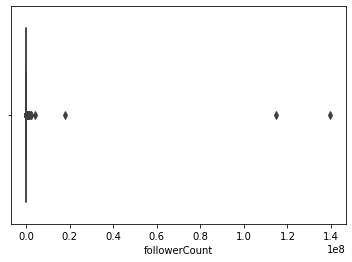

In [643]:
import seaborn as sns
sns.boxplot(x=dfna['followerCount'])

In [654]:
#
def drop_anomaly(df, cols):
    temp = df.copy()
    for i in cols:
        q1 = dfna[i].quantile(0.25)
        q3 = dfna[i].quantile(0.75)
        IQR = q3-q1
        temp = temp[(temp[i]>=(q1-1.5*IQR)) * (temp[i]<=(q3+1.5*IQR))]
        print(i, temp.shape)
    return temp
cols_to_check_anomaly = dfna.describe().columns
dfnew = drop_anomaly(dfnew,cols_to_check_anomaly)

mediaCount (896, 50)
followingCount (810, 50)
followerCount (720, 50)
usertagsCount (668, 50)
shoppablePostsCount (659, 50)
followingTagCount (610, 50)


# Fit Models

In [657]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
import sklearn.metrics as metrics

def evaluation_classmodel(ytest, ypred, ypred_prob = ypred_prob):
    print("Accuracy: %s:" % metrics.accuracy_score(ytest, ypred))
    print("F1: %s:" %metrics.f1_score(ytest, ypred))
    print("Precision: %s:" %metrics.precision_score(ytest, ypred))
    print("Recall: %s:" %metrics.recall_score(ytest, ypred))
    print("\n\n")
    print(metrics.confusion_matrix(ytest,ypred, labels = np.array([1,0])))
    tn, fp, fn, tp = metrics.confusion_matrix(ytest,ypred).ravel()
    print("(tn, fp, fn, tp)")
    print((tn, fp, fn, tp))
    print("\n\n")
    try:
        score = ypred_prob[:,1]
        fpr, tpr, threshold = metrics.roc_curve(ytest, score)
        roc_auc = metrics.auc(fpr, tpr)
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
    except:
        None
        
def adjust_thres(model, xtest, ytest, startthres):
    curr = startthres
    curracc = 0
    score = model.predict_proba(xtest)[:,1]
    for i in range(1,50):
        curr += 0.01
        acc = ((score>curr)==ytest).sum()/len(ytest)
        print(curr, acc)

labels = np.array(dfnew.pop('brand'))
xtrain, xtest, ytrain, ytest = train_test_split(dfnew,
                                         labels, 
                                         stratify = labels,
                                         test_size = 0.3, 
                                         random_state = 1)
scaler = preprocessing.StandardScaler().fit(xtrain)
xtrainscaled = scaler.transform(xtrain)
xtestscaled = scaler.transform(xtest)

Accuracy: 0.8032786885245902:
F1: 0.7954545454545455:
Precision: 0.8333333333333334:
Recall: 0.7608695652173914:



[[70 22]
 [14 77]]
(tn, fp, fn, tp)
(77, 14, 22, 70)





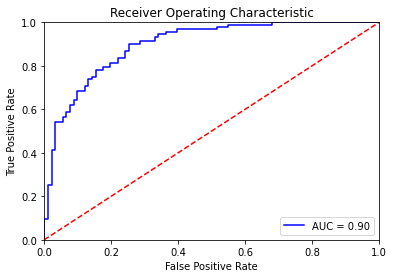

0.31 0.8142076502732241
0.32 0.8142076502732241
0.33 0.825136612021858
0.34 0.825136612021858
0.35000000000000003 0.825136612021858
0.36000000000000004 0.8142076502732241
0.37000000000000005 0.8087431693989071
0.38000000000000006 0.7978142076502732
0.39000000000000007 0.8032786885245902
0.4000000000000001 0.8032786885245902
0.4100000000000001 0.7978142076502732
0.4200000000000001 0.8032786885245902
0.4300000000000001 0.8032786885245902
0.4400000000000001 0.8032786885245902
0.4500000000000001 0.8032786885245902
0.46000000000000013 0.8032786885245902
0.47000000000000014 0.8032786885245902
0.48000000000000015 0.8087431693989071
0.49000000000000016 0.8087431693989071
0.5000000000000001 0.8032786885245902
0.5100000000000001 0.7978142076502732
0.5200000000000001 0.7978142076502732
0.5300000000000001 0.8032786885245902
0.5400000000000001 0.8032786885245902
0.5500000000000002 0.7978142076502732
0.5600000000000002 0.7978142076502732
0.5700000000000002 0.8032786885245902
0.5800000000000002 0.803

In [670]:
#Fit RandomForest with GridSearchCV
#AUC Score of 0.90
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
features = list(train.columns)
# Create the model with 100 trees
rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(xtrainscaled, ytrain)
grid_search.best_params_
gridrf = grid_search.best_estimator_
ypred = gridrf.predict(xtestscaled) 
ypred_prob = gridrf.predict_proba(xtestscaled)
evaluation_classmodel(ytest, ypred, ypred_prob)
adjust_thres(gridrf, xtestscaled, ytest, 0.3)

Fitting 3 folds for each of 2160 candidates, totalling 6480 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 188 tasks      | elapsed:    7.0s
[Parallel(n_jobs=4)]: Done 508 tasks      | elapsed:   17.9s
[Parallel(n_jobs=4)]: Done 956 tasks      | elapsed:   32.9s
[Parallel(n_jobs=4)]: Done 1532 tasks      | elapsed:   52.0s
[Parallel(n_jobs=4)]: Done 2236 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 3068 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 4028 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 5116 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 6332 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 6480 out of 6480 | elapsed:  4.7min finished


[16:02:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy: 0.825136612021858:
F1: 0.8279569892473119:
Precision: 0.8191489361702128:
Recall: 0.8369565217391305:



[[77 15]
 [17 74]]
(tn, fp, fn, tp)
(74, 17, 15, 77)





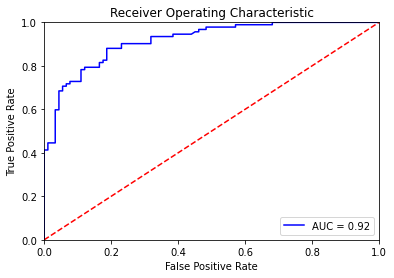

0.41000000000000003 0.8306010928961749
0.42000000000000004 0.8306010928961749
0.43000000000000005 0.8360655737704918
0.44000000000000006 0.8360655737704918
0.45000000000000007 0.8415300546448088
0.4600000000000001 0.8415300546448088
0.4700000000000001 0.8360655737704918
0.4800000000000001 0.8306010928961749
0.4900000000000001 0.825136612021858
0.5000000000000001 0.825136612021858
0.5100000000000001 0.825136612021858
0.5200000000000001 0.819672131147541
0.5300000000000001 0.819672131147541
0.5400000000000001 0.825136612021858
0.5500000000000002 0.819672131147541
0.5600000000000002 0.825136612021858
0.5700000000000002 0.825136612021858
0.5800000000000002 0.825136612021858
0.5900000000000002 0.825136612021858
0.6000000000000002 0.825136612021858
0.6100000000000002 0.819672131147541
0.6200000000000002 0.819672131147541
0.6300000000000002 0.8142076502732241
0.6400000000000002 0.819672131147541
0.6500000000000002 0.8360655737704918
0.6600000000000003 0.8360655737704918
0.6700000000000003 0.8

In [660]:
#Fit XGboost with GridSearchCV
#AUC score is 0.92 meaning that xgboost model is really good at differientiating between the two classess influencer and company brand

from xgboost import XGBClassifier
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [2, 3, 4, 5],
    "n_estimators":[100,400,700,900]
        }
xgb = XGBClassifier(learning_rate=0.02, objective='binary:logistic',
                    silent=True, nthread=1)
gridxgb = GridSearchCV(estimator=xgb, param_grid=params, scoring='roc_auc', n_jobs=4, cv=3, verbose=3 )
gridxgb.fit(xtrainscaled, ytrain)
xgbypred = gridxgb.predict(xtestscaled) 
xgbypred_prob = gridxgb.predict_proba(xtestscaled)
evaluation_classmodel(ytest, xgbypred, xgbypred_prob)
adjust_thres(gridxgb, xtestscaled, ytest, 0.4)

# Feature Importance

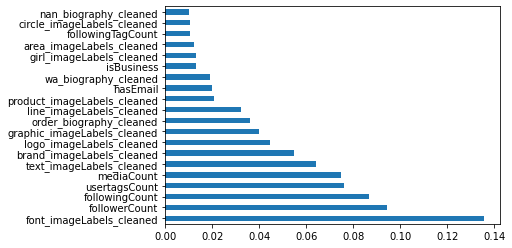

In [663]:
model = RandomForestClassifier()
model.fit(xtrain, ytrain)

(pd.Series(model.feature_importances_, index=xtrain.columns)
   .nlargest(20)
   .plot(kind='barh')) 

In [668]:
# Most Influencer do not have font in their image Labels and most brand have fonts in their imagelabels

def get_breakdown_bycol(dfna,newcols,col_lst):
    for i in col_lst:
        print(pd.concat([dfna,newcols],axis=1).groupby(["brand",i]).agg({i:"count"}).groupby(level=0).apply(lambda x:
                                                         100 * x / float(x.sum())))
get_breakdown_bycol(dfna,newcols,["font_imageLabels_cleaned"])



                                font_imageLabels_cleaned
brand font_imageLabels_cleaned                          
False 0.0                                      86.383929
      1.0                                      13.616071
True  0.0                                      29.357798
      1.0                                      70.642202


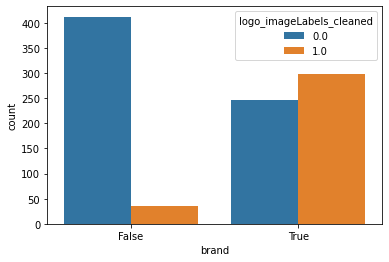

In [669]:
#Almost all of the influencers do not have logos in their imagelabels which make sense as most influencer profile pic shows themselves rather than a company logo. 
# Whereas a majority of the company brand has logos in it.

temp = pd.concat([dfna,newcols],axis=1).groupby(["brand","logo_imageLabels_cleaned"])["logo_imageLabels_cleaned"].agg({"count"}).reset_index()
sns.barplot(x="brand", y="count", hue="logo_imageLabels_cleaned", data=temp)